# Proyecto de Máquinas de Aprendizaje - ILI393
## _Identificación facial cuando existen pocos ejemplos por clase_

## El Problema

El problema consiste en la correcta identificación y reconocimiento facial, dado el caso particular en donde existen muy pocos ejemplos por clase (por persona) para entrenar los algoritmos algoritmos de clasificación. La mayoría de los enfoques usados en este tipo de problemas consisten en encontrar una buena representación de las características importantes de las caras, para posteriormente realizar algún tipo de búsqueda (jerárquica, nearest neighbors, etc). Sin embargo se propone aquí resolver el problema con tres algoritmos de clasificación distintos: Linear Discriminant Analysis, Support Vector Machines (con kernel lineal y radio basal) y por Convolutional Neural Networks.

Los dataset a ocupar son [Faces94](http://cswww.essex.ac.uk/mv/allfaces/faces94.html), [Faces95](http://cswww.essex.ac.uk/mv/allfaces/faces95.html) y [Faces96](http://cswww.essex.ac.uk/mv/allfaces/faces96.html). Cada uno de los datasets consiste en 20 imágenes de individuos, y variable cantidad de individuos. Los datasets estan ordenados en cuanto a su complejidad de reconocimiento de menor a mayor. Se muestran a continuación imágenes representativas de Faces94, Faces95 y Faces96 respectivamente.

<img src="faces94ex.jpg">

<img src="faces95ex.jpg">

<img src="faces96ex.jpg">

Para cada uno de estos datasets, se crearon training y testing sets correspondientes. La metodología fue la siguiente: Para cada dataset (94,95,96) se tomaron aleatoreamente entre 2-5 fotos por clase (por persona) para formar los training sets correspondientes, y las restantes 15-18 fotos se dejaron para crear los testing sets correspondientes. Vale decir, si se entrena con train94/5pc (faces94, 5 samples per class) entonces se testea con test94/15pc (faces94, 15 samples per class). Cumpliendo de este modo con la reestricción de tener pocos samples para entrenar los algoritmos.

## Enfoque 1: Linear Discriminant Analysis

### 1) LDA con Faces94

#####################################################################################
Dataset faces94: 2 samples per class
Error rate: 0.0198675496689


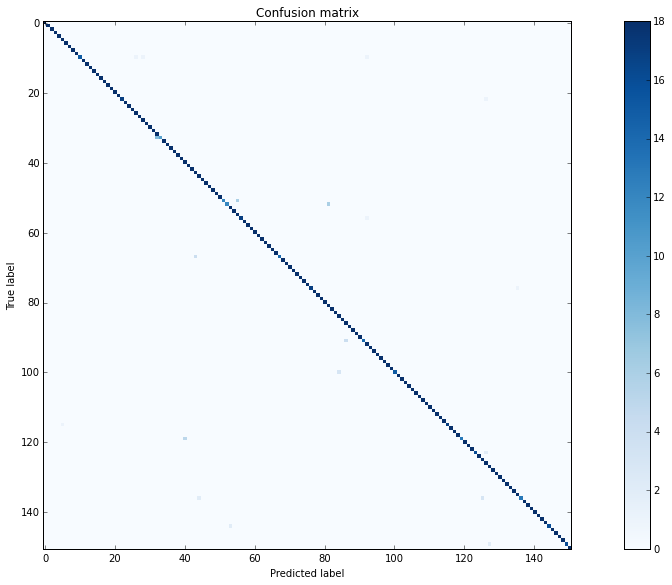

#####################################################################################
#####################################################################################
Dataset faces94: 3 samples per class
Error rate: 0.002726918582


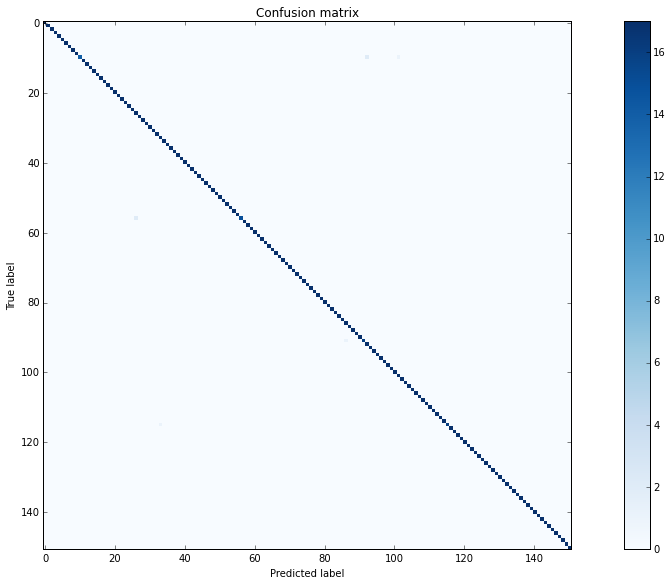

#####################################################################################
#####################################################################################
Dataset faces94: 4 samples per class
Error rate: 0.00703642384106


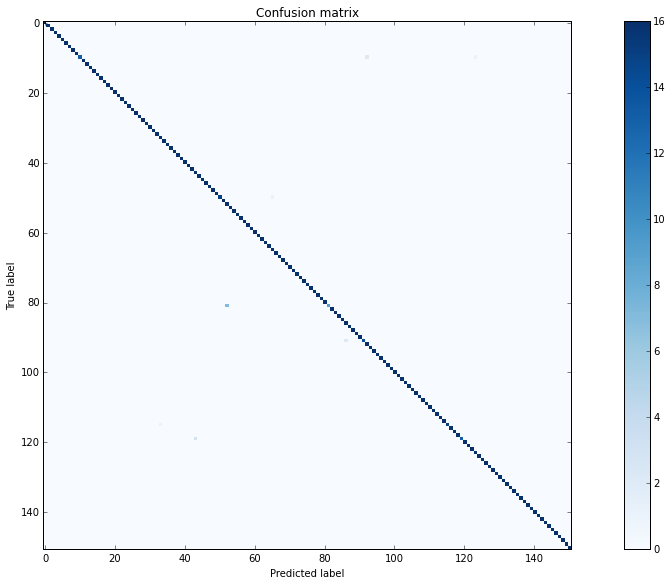

#####################################################################################
#####################################################################################
Dataset faces94: 5 samples per class
Error rate: 0.00353200883002


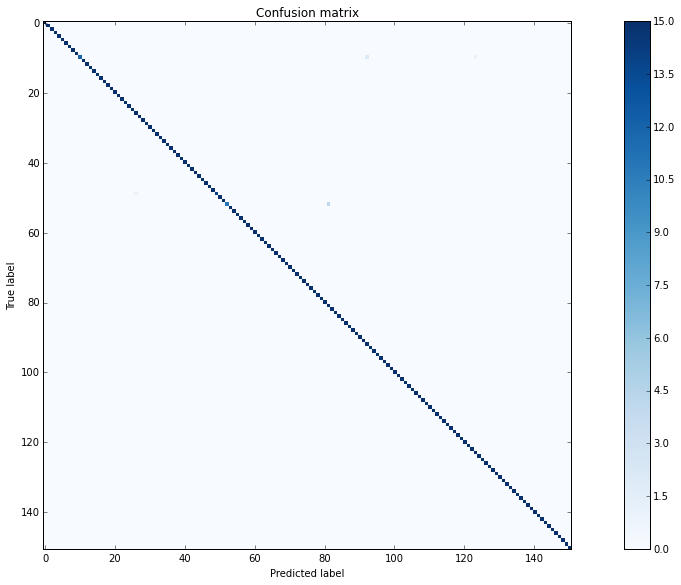

#####################################################################################


In [96]:
for i in range(2,6):
    solve_lda('faces94',i)

### LDA con Faces95

#####################################################################################
Dataset faces95: 2 samples per class
Error rate: 0.360719874804


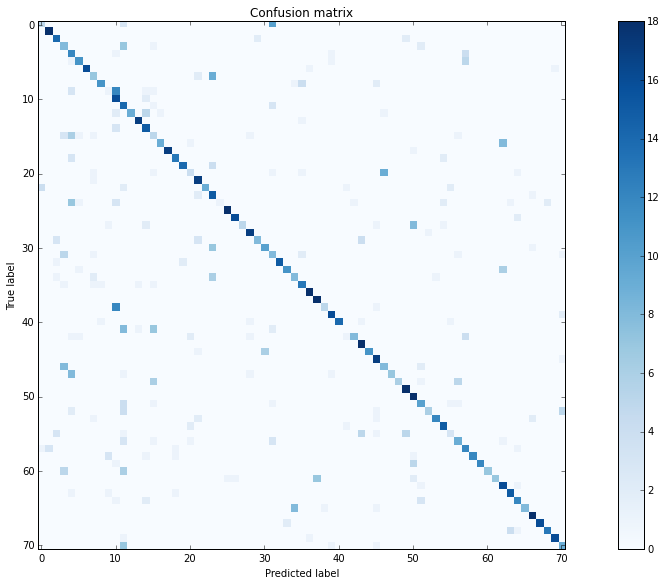

#####################################################################################
#####################################################################################
Dataset faces95: 3 samples per class
Error rate: 0.262634631317


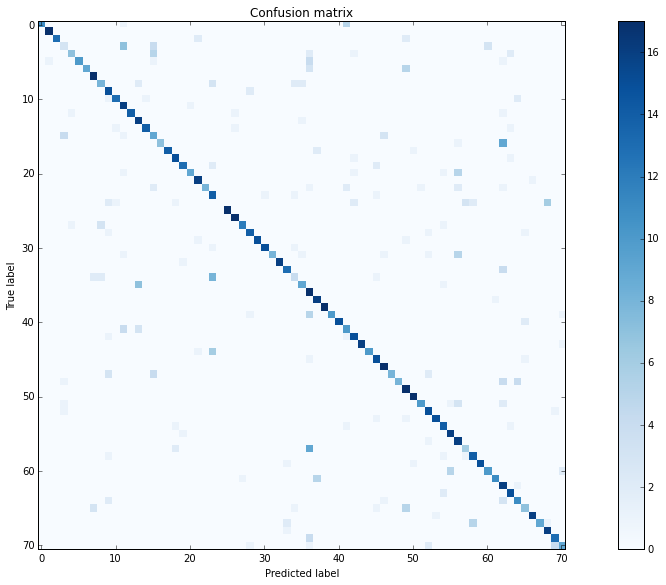

#####################################################################################
#####################################################################################
Dataset faces95: 4 samples per class
Error rate: 0.197183098592


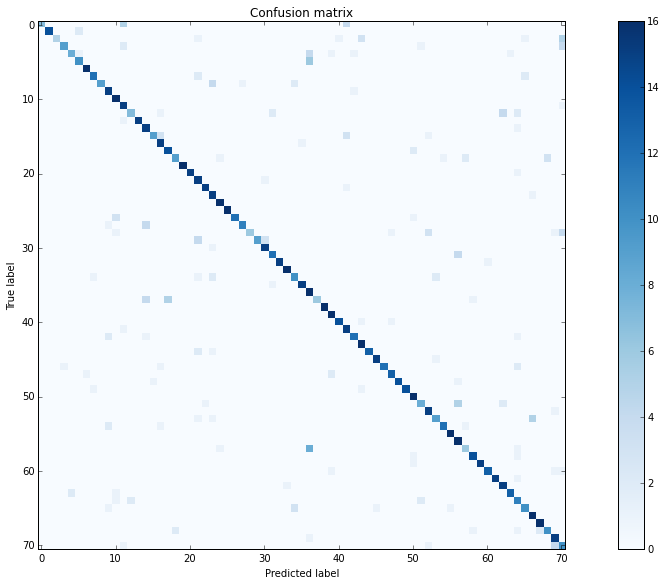

#####################################################################################
#####################################################################################
Dataset faces95: 5 samples per class
Error rate: 0.148356807512


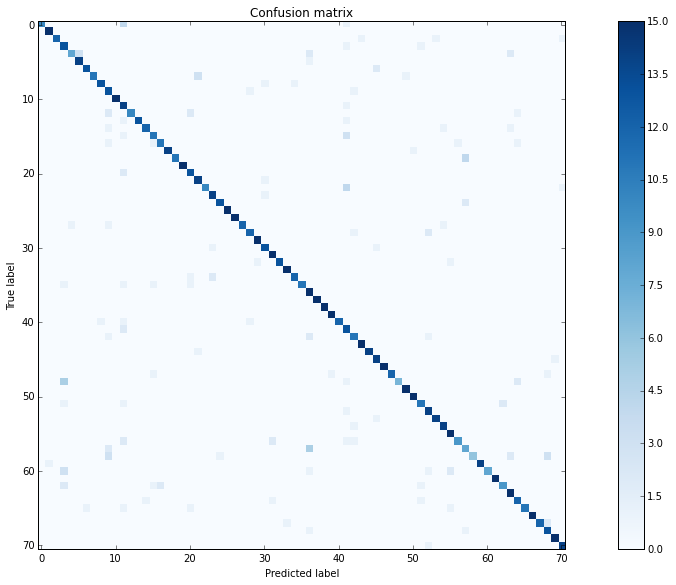

#####################################################################################


In [97]:
for i in range(2,6):
    solve_lda('faces95',i)

## Enfoque 2: Support Vector Machines

Para hacer las comparaciones entre este enfoque y el anterior, se ha decidido ocupar LDA para reducción de dimensionalidad en las imágenes, representación conocida como _Fisher Faces_.

### 1) Linear SVM

### Linear-SVM con Faces94

#####################################################################################
Dataset faces94: 2 samples per class
Best C: 1.0


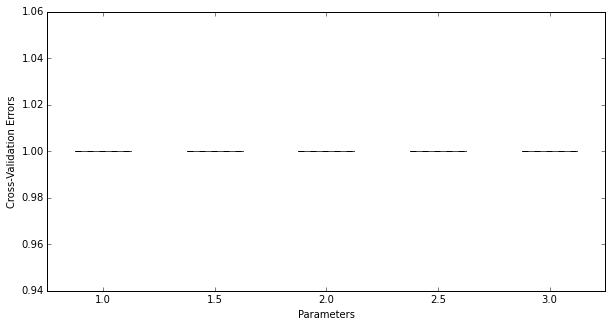

Error rate: 0.0176600441501


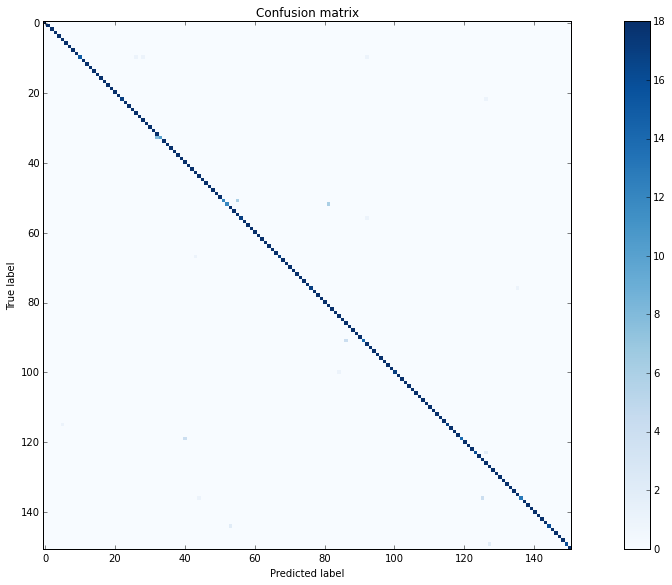

#####################################################################################
#####################################################################################
Dataset faces94: 3 samples per class
Best C: 1.5


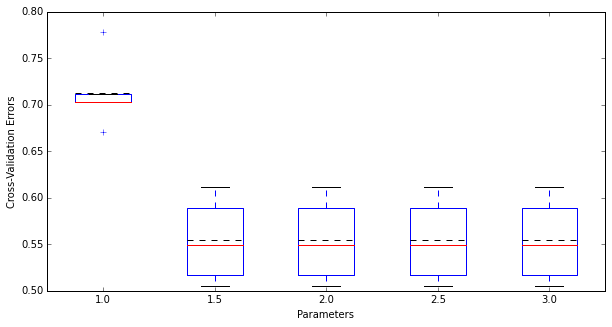

Error rate: 0.00155823918972


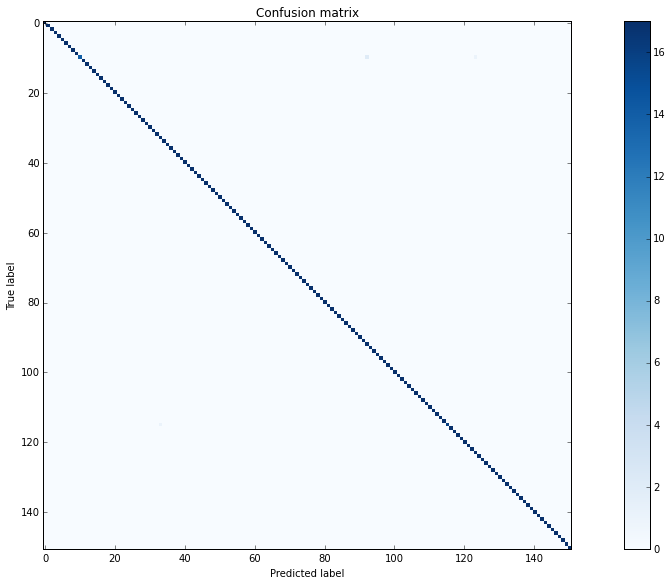

#####################################################################################
#####################################################################################
Dataset faces94: 4 samples per class
Best C: 2.0


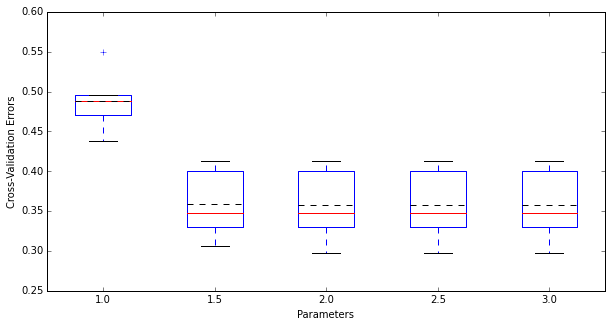

Error rate: 0.00165562913907


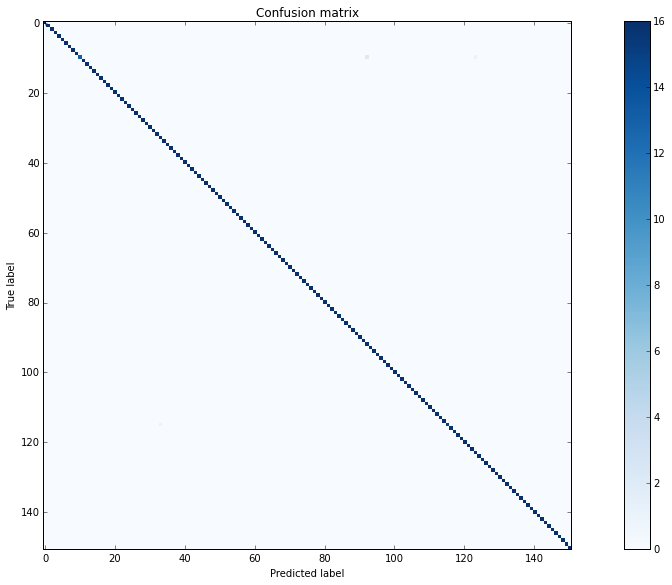

#####################################################################################
#####################################################################################
Dataset faces94: 5 samples per class
Best C: 1.5


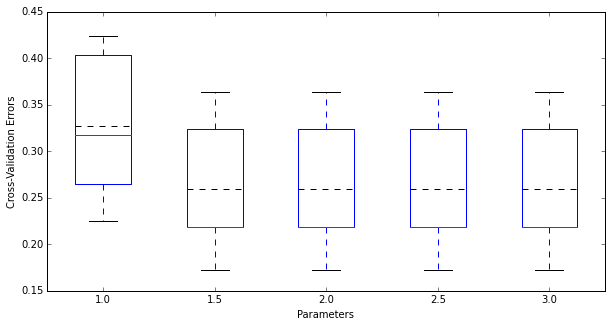

Error rate: 0.00176600441501


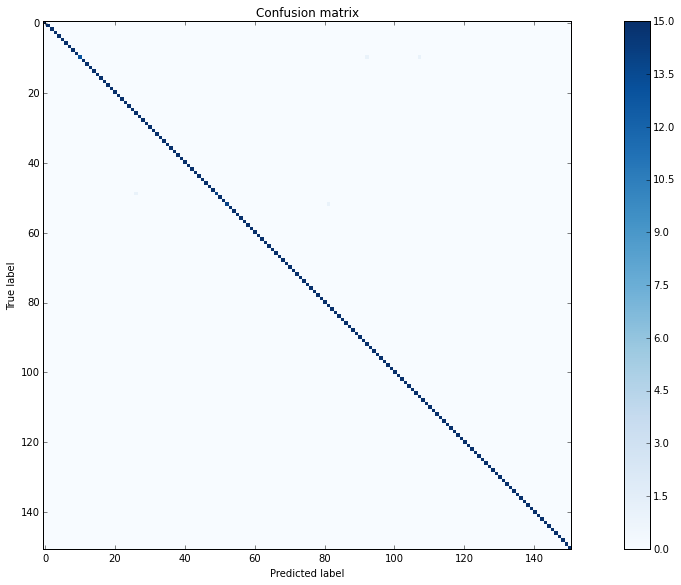

#####################################################################################


In [106]:
for spc in range(2,6):
    solve_svm('faces94', spc, C, kernel='linear')

### Linear-SVM con Faces94

#####################################################################################
Dataset faces95: 2 samples per class
Best C: 1.0


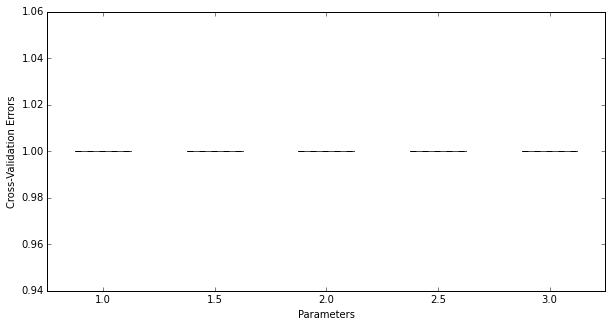

Error rate: 0.320813771518


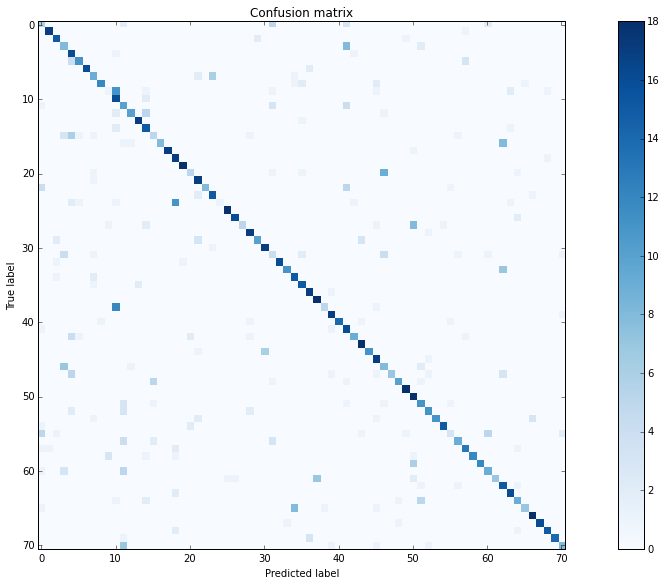

#####################################################################################
#####################################################################################
Dataset faces95: 3 samples per class
Best C: 2.0


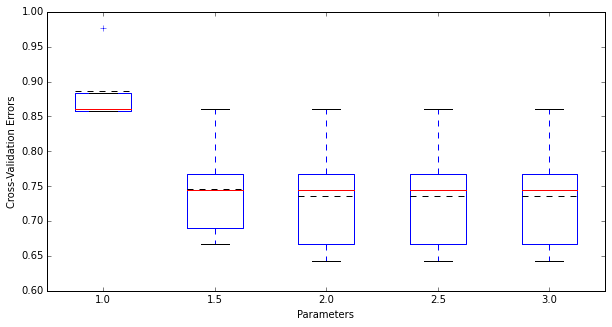

Error rate: 0.214581607291


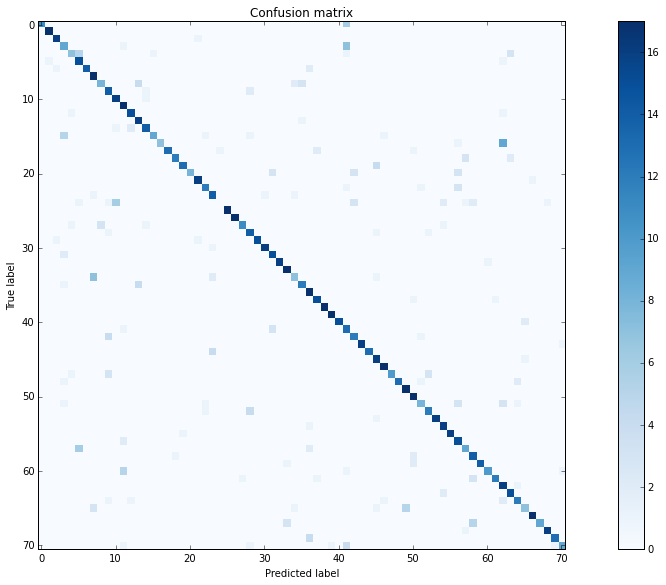

#####################################################################################
#####################################################################################
Dataset faces95: 4 samples per class
Best C: 2.0


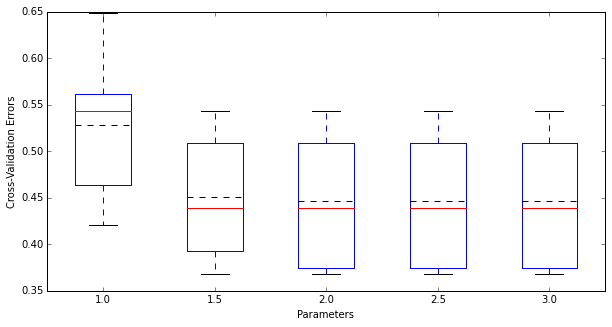

Error rate: 0.153169014085


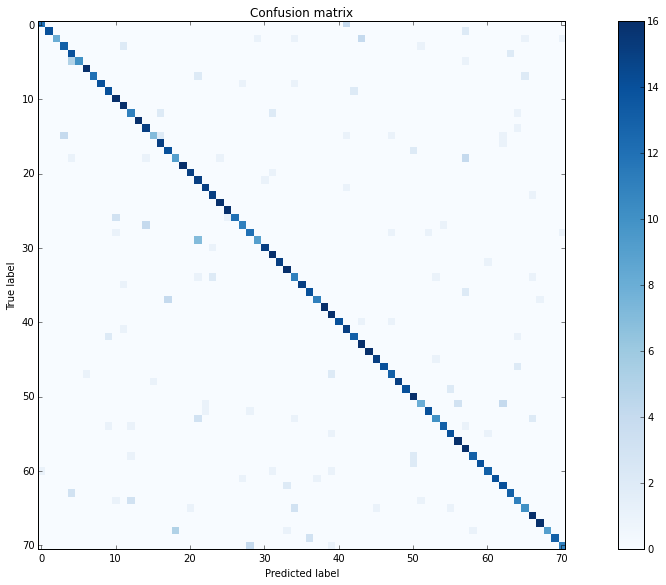

#####################################################################################
#####################################################################################
Dataset faces95: 5 samples per class
Best C: 2.0


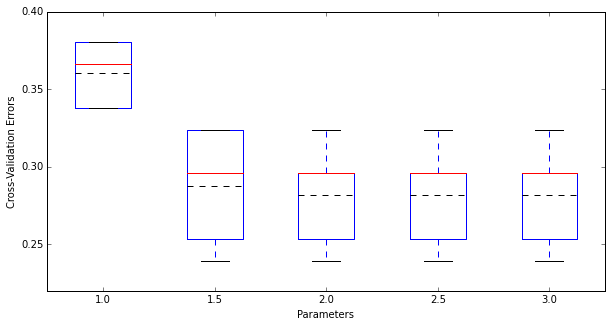

Error rate: 0.106103286385


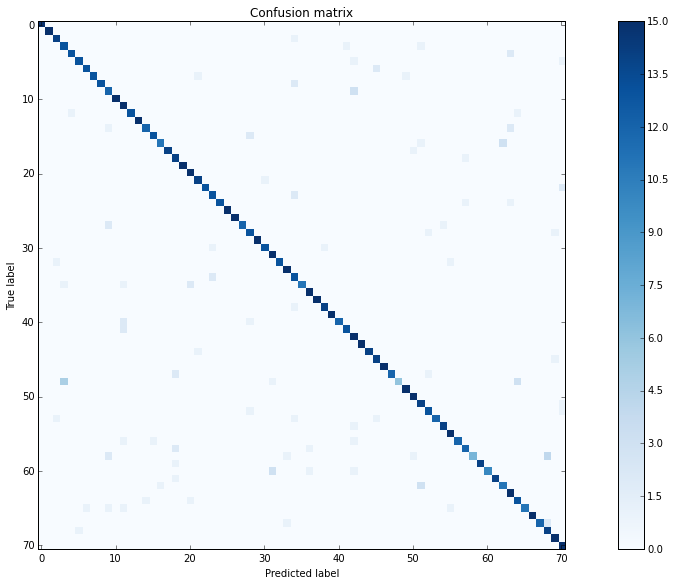

#####################################################################################


In [108]:
for spc in range(2,6):
    solve_svm('faces95', spc, C, kernel='linear')

### 2) Kernel-SVM

### Kernel-SVM con Faces94 

### Kernel-SVM con Faces95

## Enfoque 3: Convolutional Neural Network

### to do...

## Anexo de Código

### Configuración del notebook

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### Helper functions

In [3]:
"""
> function to load data from path directory to a matrix.
> each row of the resulting matrix, corresponds to a flattened image
  in grayscale format
"""
def load_data(path, spc):
    path = path+str(spc)+'pc/'
    #total number of classes
    M = len(os.listdir(path))
    #dimensions of each image
    N = 200*180
    #matrix with features and labels
    data = np.empty((M*spc,N+1))
    #index of data matrix
    m = 0
    for i in range(1,M+1):
        tgt = path+str(i)+'/'
        pics = os.listdir(tgt)
        for pic in pics:
            #store each flattened image, as a row in data matrix
            data[m,0:-1] = cv.imread(tgt+pic, cv.IMREAD_GRAYSCALE).ravel()
            data[m,-1] = i
            m +=1
    #just to verify that orden doesn't affect results
    np.random.shuffle(data)
    return (data[:,0:-1], data[:,-1])

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(15,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Funciones de error

In [9]:
def precision(y_ts, y_pd):
    #true positives
    tp = (y_ts==y_pd).sum()
    #total of predictions
    n = y_ts.shape[0]
    return tp/np.float(n)

def error_rate(y_ts, y_pd):
    return 1-precision(y_ts, y_pd)

### Funciones para LDA

In [15]:
def solve_lda(dataset, spc):
    #samples per class on training set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #loading training and testing set
    X_tr,y_tr = load_data('./db/train'+dataset[-2:]+'/', spc_tr)
    X_ts,y_ts = load_data('./db/test'+dataset[-2:]+'/', spc_ts)
    #creating LDA object and fitting the testing data
    clf = LDA()
    clf.fit(X_tr, y_tr)
    #making predictions
    y_pd = clf.predict(X_ts)
    
    print "#####################################################################################"
    print "Dataset {0}: {1} samples per class".format(dataset,spc)
    #computing the confussion matrix and plotting results
    print "Error rate: {0}".format(error_rate(y_ts,y_pd))
    cm = confusion_matrix(y_ts, y_pd)
    plot_confusion_matrix(cm)
    print "#####################################################################################"
    #releasing memory of big objects
    del X_tr, X_ts, clf, cm

### Funciones para SVM

In [105]:
"""
Supervised dimensionality reduction through LDA
"""
def fisher_faces(X, y):
    #supervised learning through LDA
    #finding the discriminant functions
    ff = LDA()
    ff.fit(X,y)
    #proyect the data into linear discriminant hyperplanes
    return ff

def cross_linear_svm(X, y, C):
    M,N = X.shape
    #generating 5-folds
    kf = KFold(M, n_folds=5)
    #array with CV-errors
    cv_err = np.empty((5,5))
    #index of parameter
    j = 0 
    for c in C:
        clf = SVC(c)
        #index of fold
        i=0
        for tr_index,ts_index in kf:
            X_tr,y_tr = X[tr_index], y[tr_index]
            X_ts,y_ts = X[ts_index], y[ts_index]
            #fitting the model
            clf.fit(X_tr,y_tr)
            #making predictions
            y_pd = clf.predict(X_ts)
            #computing error rate
            cv_err[i,j] = error_rate(y_ts, y_pd)
            i +=1
        j += 1
    #mean cv-error
    cv_mean = np.mean(cv_err, axis=0)
    return C[np.argmin(cv_mean)], cv_err

def cross_rbf_svm(X, y, C, Gamma):
    return

#solve lsvm
def solve_svm(dataset, spc, C, kernel='linear', Gamma=None):
    #samples per class on training set
    spc_tr = spc
    spc_ts = 20-spc_tr
    #loading training and testing set
    X_tr,y_tr = load_data('./db/train'+dataset[-2:]+'/', spc_tr)
    X_ts,y_ts = load_data('./db/test'+dataset[-2:]+'/', spc_ts)
    #projecting into discriminant space
    ff = fisher_faces(X_tr, y_tr)
    X_tr = ff.transform(X_tr)
    X_ts = ff.transform(X_ts)
    #choosing best c (and gamma) through 5-fold cross-validation
    if kernel=='linear':
        c,cv_err = cross_linear_svm(X_tr, y_tr, C)
    elif kernel=='rbf':
        c,gamma,cv_err = cross_rbf_svm(X_tr, y_tr, C, Gamma)
    #fitting the model
    if kernel=='linear':
        clf = SVC(c, kernel='linear')
    elif kernel=='rbf':
        clf = SVC(c, gamma, kernel='rbf')    
    clf.fit(X_tr,y_tr)
    #making predictions
    y_pd = clf.predict(X_ts)
    print "#####################################################################################"
    print "Dataset {0}: {1} samples per class".format(dataset,spc)
    print "Best C: {0}".format(c)
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.xlabel('Parameters')
    plt.ylabel('Cross-Validation Errors')
    plt.boxplot(cv_err, showmeans=True, meanline=True)
    plt.xticks([1, 2, 3, 4, 5], map(str,C))
    plt.show()
    print "Error rate: {0}".format(error_rate(y_ts, y_pd))
    #computing the confussion matrix and plotting results
    cm = confusion_matrix(y_ts, y_pd)
    plot_confusion_matrix(cm)
    print "#####################################################################################"

In [117]:
C = np.linspace(10,100,5)

#####################################################################################
Dataset faces95: 2 samples per class
Best C: 10.0


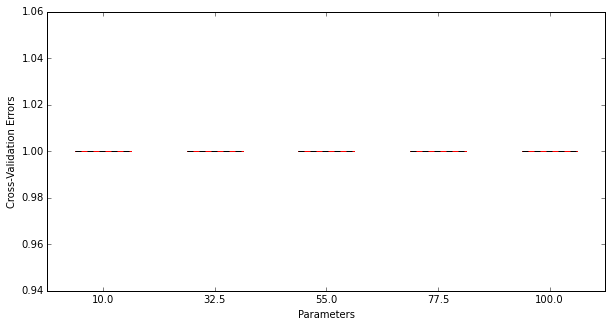

Error rate: 0.320813771518


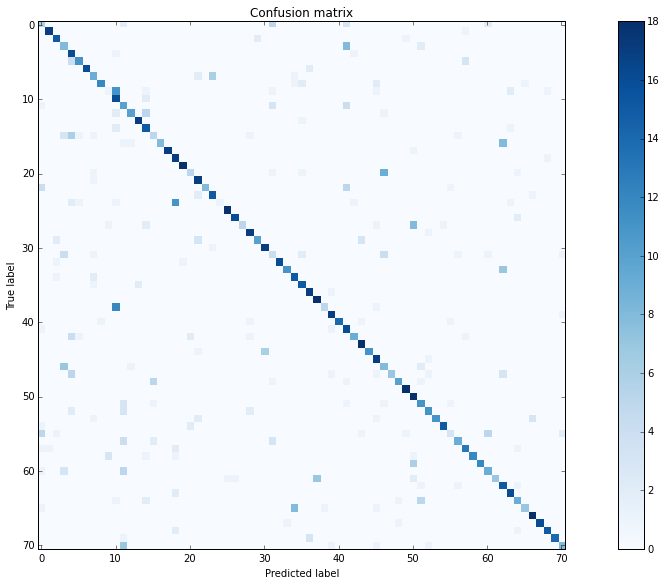

#####################################################################################


In [118]:
solve_svm('faces95', 2, C)